In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
from tensorflow.keras.layers import Attention

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

In [3]:
image_path = '/content/drive/MyDrive/Flickr 8k/Images'

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Flickr 8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Flickr 8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

# **Visualization**
- Images and their corresponding captions

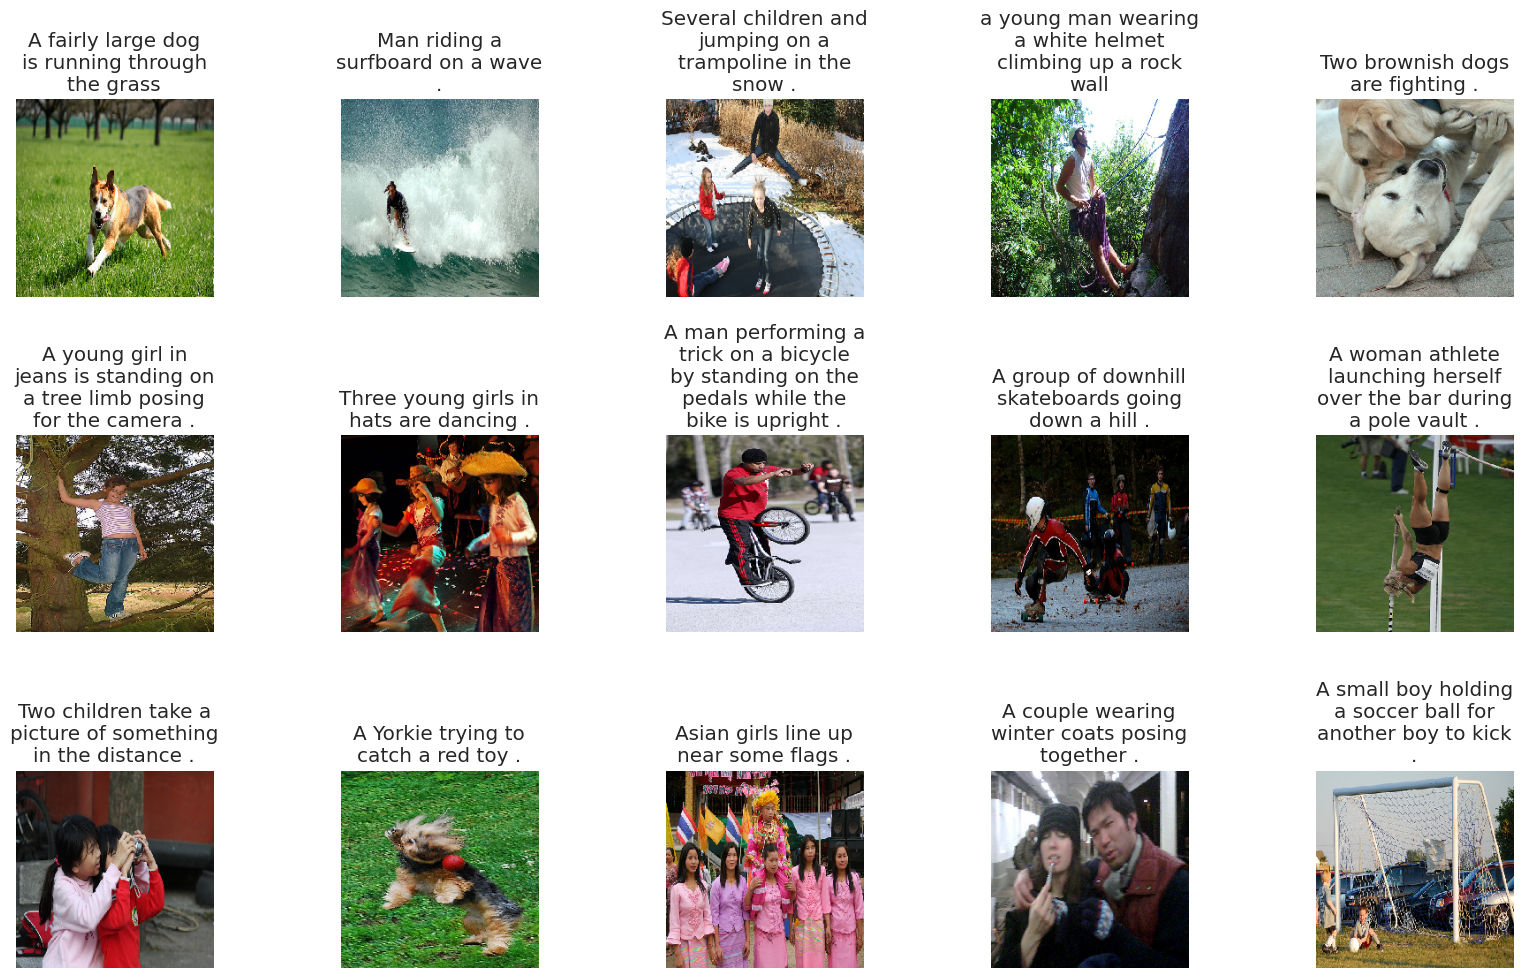

In [ ]:
display_images(data.sample(15))

# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [6]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

## __Preprocessed Text__

In [7]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [88]:
test


image  \
0     3688858505_e8afd1475d.jpg   
1     3688858505_e8afd1475d.jpg   
2     3688858505_e8afd1475d.jpg   
3     3688858505_e8afd1475d.jpg   
4     3688858505_e8afd1475d.jpg   
...                         ...   
6065   997722733_0cb5439472.jpg   
6066   997722733_0cb5439472.jpg   
6067   997722733_0cb5439472.jpg   
6068   997722733_0cb5439472.jpg   
6069   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq few people with girl standing up in t...  
2              startseq girl is wear green dress endseq  
3     startseq blonde girl wearing green dress stand...  
4     startseq woman in green dress being observed e...  
...                                                 ...  
6065  startseq man in pink shirt climbs rock face en...  
6066  startseq man is rock climbing high in the air ...  
6067  startseq person in red shirt climbing up rock ...  
6068          startseq rock climber in red shirt endseq  
6069  startseq rock climber practices on rock climbi...  

[6070 rows x 2 columns]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

2024-12-18 00:27:36.552747: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2024-12-18 00:27:36.552799: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-12-18 00:27:36.552809: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-12-18 00:27:36.553015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-18 00:27:36.553034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-18 00:27:39.506090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.

00%|██████████████████████

In [9]:
import pickle
feature_path ='/content/drive/MyDrive/Flickr 8k/Features'
#pickle.dump(features,open(os.path.join(feature_path,'densenet201_flickr 8k.pkl'),'wb'))


In [10]:
#load feqatures from pickel
with open(os.path.join(feature_path,'densenet201_flickr 8k.pkl'),'rb') as f:
    features=pickle.load(f)

# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [11]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [73]:
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# model with out attention mechanism
from tensorflow.keras.layers import (
    Input, Dense, Reshape, Embedding, LSTM, Bidirectional, Dropout, add, concatenate, Masking
)
from tensorflow.keras.models import Model
import tensorflow as tf

# Input layers
input1 = Input(shape=(1920,))  # Image feature vector input
input2 = Input(shape=(max_length,))  # Text input (caption)

# Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)  # Reshape to match LSTM output shape

# Sentence feature processing with BiLSTM and masking
sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input2)

# Explicitly remove mask before concatenation
sentence_features = tf.keras.layers.Lambda(lambda x: x)(sentence_features)  # Removes the mask

# Concatenate image and sentence features
merged = concatenate([img_features_reshaped, sentence_features], axis=1)

# Optional: Apply Masking Layer after concatenation
masked_merged = Masking(mask_value=0.0)(merged)

# Process merged features with BiLSTM
sentence_features = Bidirectional(LSTM(128, return_sequences=False))(masked_merged)
sentence_features = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(sentence_features)

# Adding dropout and merging features
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])  # Ensure shape matches

# Final dense layers
x = Dense(512, activation='relu',kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Define and compile the model
caption_model0 = Model(inputs=[input1, input2], outputs=output)
caption_model0.compile(loss='categorical_crossentropy', optimizer='adam')


In [56]:
from tensorflow.keras.layers import Attention, RepeatVector, Permute, TimeDistributed, Multiply, Lambda, Embedding, LSTM, Dense, Dropout, Reshape, Bidirectional, add, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow as tf

# model with attention machanism with some tuning

# Input layers
input1 = Input(shape=(1920,))  # Image feature vector input
input2 = Input(shape=(max_length,))  # Text input (caption)

# Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)  # Reshape to match LSTM output shape

# Sentence feature processing with BiLSTM and embedding
sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input2)

# Apply BiLSTM to text features
lstm_output = Bidirectional(LSTM(128, return_sequences=False))(sentence_features)

# Expand dims to match attention input requirements
expand_dims_layer = Lambda(lambda x: tf.expand_dims(x, axis=1))  # Keras-compatible expand_dims
lstm_output_expanded = expand_dims_layer(lstm_output)

# Apply attention between image and text features
context = Attention()([img_features_reshaped, lstm_output_expanded])

# Flatten context and pass through dense layer
context = Flatten()(context)
context = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(context)

# Combine attended context with image features
merged = add([context, img_features])

# Final dense layers
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(merged)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Define and compile the model
caption_model1 = Model(inputs=[input1, input2], outputs=output)
caption_model1.compile(loss='categorical_crossentropy', optimizer='adam')

caption_model1.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_6 (NotEqual)    │ (None, 34)             │              0 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 256)            │        491,776 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 256)            │        394,240 │ embedding_6[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 256)         │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 1, 256)         │              0 │ bidirectional_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_6 (Attention)   │ (None, 1, 256)         │              0 │ reshape_6[0][0],       │
│                           │                        │                │ lambda_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 256)            │              0 │ attention_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 256)            │         65,792 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 256)            │              0 │ dense_23[0][0],        │
│                           │                        │                │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 512)            │        131,584 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 8485)           │      4,352,805 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,608,357 (29.02 MB)

 Trainable params: 7,608,357 (29.02 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# model with attention mechanism
from tensorflow.keras.layers import Attention, RepeatVector, Permute, TimeDistributed, Multiply, Lambda, Embedding, LSTM, Dense, Dropout, Reshape, Bidirectional, add, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

# Input layers
input1 = Input(shape=(1920,))  # Image feature vector input
input2 = Input(shape=(max_length,))  # Text input (caption)

# Image feature processing
img_features = Dense(512, activation='relu')(input1)
img_features_reshaped = Reshape((1, 512))(img_features)  # Reshape to match LSTM output shape

# Sentence feature processing with BiLSTM and embedding
sentence_features = Embedding(vocab_size, 512, mask_zero=True)(input2)

# Apply BiLSTM to text features
lstm_output = Bidirectional(LSTM(256, return_sequences=False, use_cudnn=False))(sentence_features)

# Expand dims to match attention input requirements
expand_dims_layer = Lambda(lambda x: tf.expand_dims(x, axis=1))  # Keras-compatible expand_dims
lstm_output_expanded = expand_dims_layer(lstm_output)

# Apply attention between image and text features
context = Attention()([img_features_reshaped, lstm_output_expanded])

# Flatten context and pass through dense layer
context = Flatten()(context)
context = Dense(512, activation='relu')(context)

# Combine attended context with image features
merged = add([context, img_features])

# Final dense layers
x = Dense(512, activation='relu')(merged)
x = Dropout(0.4)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Define and compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

caption_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 34, 512)        │      4,344,320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 34)             │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │        983,552 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 512)            │      1,574,912 │ embedding_1[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 512)         │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 1, 512)         │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 1, 512)         │              0 │ reshape_1[0][0],       │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 512)            │              0 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │        262,656 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 512)            │              0 │ dense_5[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 512)            │        262,656 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 8485)           │      4,352,805 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,780,901 (44.94 MB)

 Trainable params: 11,780,901 (44.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

In [75]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [76]:
model_name = "experimentdensenetflickr 8k.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
model = VGG16()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam

# Set the learning rate to 1e-5
optimizer = Adam(learning_rate=1e-5)

# Compile the model with the custom learning rate
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)



553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## **Let's train the Model !**

<img src='https://miro.medium.com/max/1400/1*xIXqf46yYonSXkUOWcOCvg.gif'>

In [77]:
noattention_history = caption_model0.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/25
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 7.1503
Epoch 1: val_loss improved from inf to 4.67830, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 200s 363ms/step - loss: 7.1477 - val_loss: 4.6783 - learning_rate: 0.0010
Epoch 2/25
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 4.5848
Epoch 2: val_loss improved from 4.67830 to 4.36405, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - loss: 4.5845 - val_loss: 4.3640 - learning_rate: 0.0010
Epoch 3/25
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 4.2804
Epoch 3: val_loss improved from 4.36405 to 4.19850, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - loss: 4.2803 - val_loss: 4.1985 - learning_rate: 0.0010
Epoch 4/25
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 4.0748
Epoch 4: val_loss improved from 4.19850 to 4.10720, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━

In [31]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 5.3144
Epoch 1: val_loss improved from inf to 3.92847, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 202s 365ms/step - loss: 5.3131 - val_loss: 3.9285 - learning_rate: 0.0010
Epoch 2/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 3.7111
Epoch 2: val_loss improved from 3.92847 to 3.58986, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 105ms/step - loss: 3.7109 - val_loss: 3.5899 - learning_rate: 0.0010
Epoch 3/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 3.3342
Epoch 3: val_loss improved from 3.58986 to 3.49096, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - loss: 3.3341 - val_loss: 3.4910 - learning_rate: 0.0010
Epoch 4/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.0897
Epoch 4: val_loss improved from 3.49096 to 3.46138, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━

In [59]:
tuned_history = caption_model1.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/10
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 7.0601
Epoch 1: val_loss improved from inf to 4.60107, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 201s 365ms/step - loss: 7.0575 - val_loss: 4.6011 - learning_rate: 0.0010
Epoch 2/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 4.4661
Epoch 2: val_loss improved from 4.60107 to 4.27224, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 57s 106ms/step - loss: 4.4658 - val_loss: 4.2722 - learning_rate: 0.0010
Epoch 3/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 4.1569
Epoch 3: val_loss improved from 4.27224 to 4.13230, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - loss: 4.1568 - val_loss: 4.1323 - learning_rate: 0.0010
Epoch 4/10
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3.9856
Epoch 4: val_loss improved from 4.13230 to 4.06949, saving model to experimentdensenetflickr 8k.keras
537/537 ━━━━━━━━

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

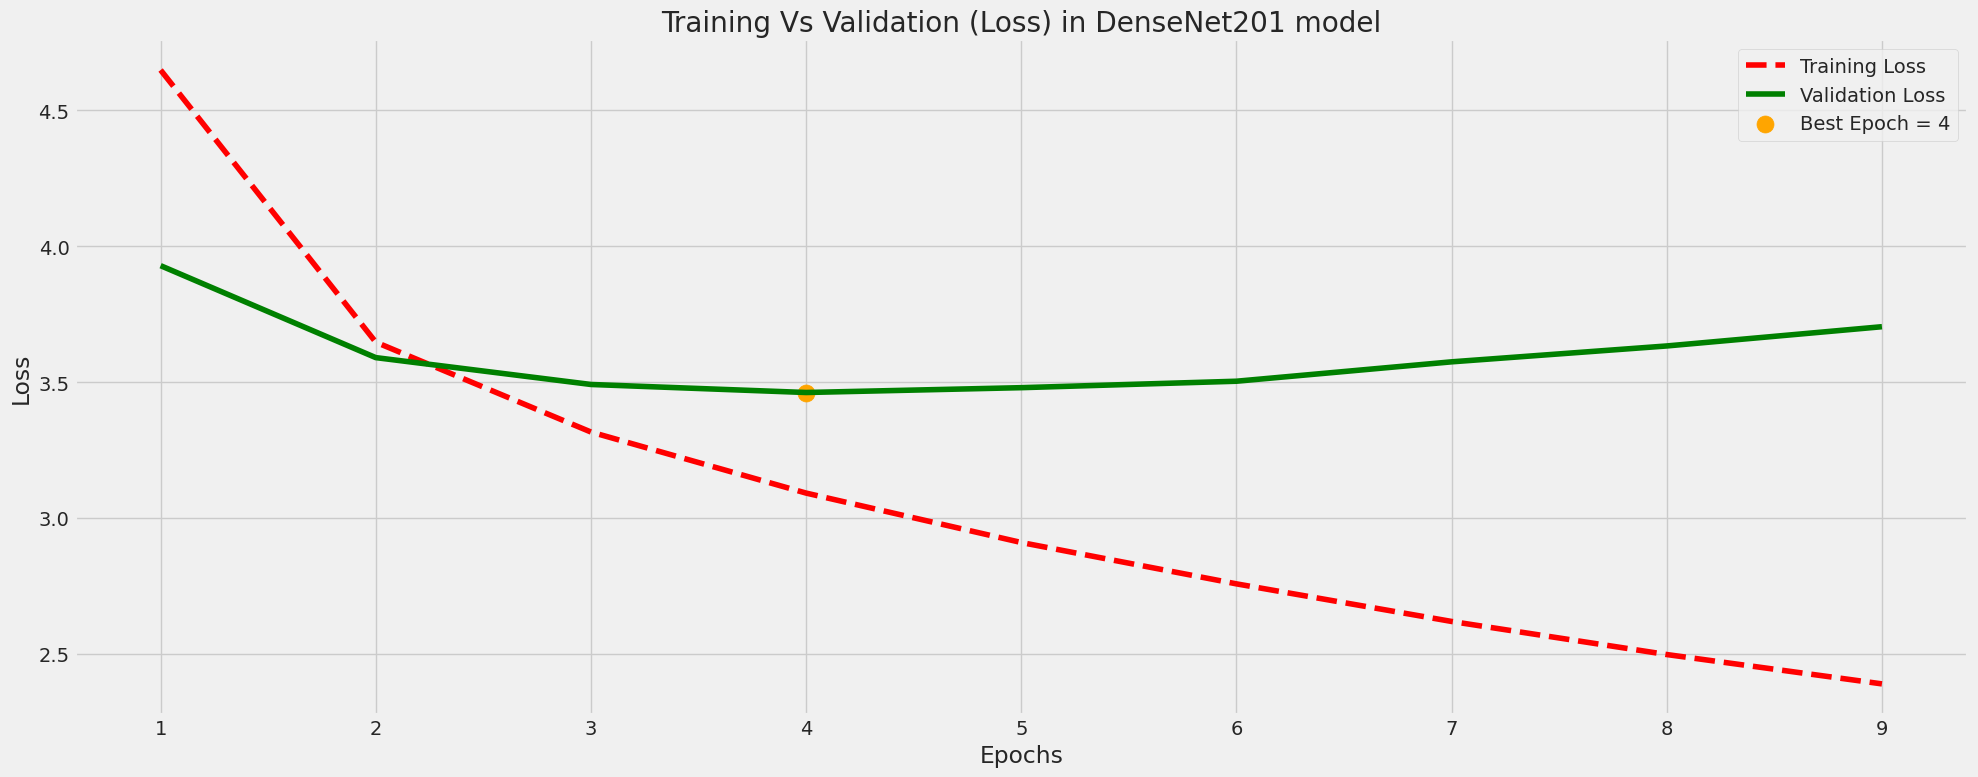

In [32]:
# Extract training and validation metrics from the history object

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]


# Generate epochs
epochs = [i+1 for i in range(len(train_loss))]

# Define labels for best epochs
loss_label = f'Best Epoch = {str(index_loss + 1)}'

# Plot training and validation loss
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='orange', label=loss_label)
plt.title('Training Vs Validation (Loss) in DenseNet201 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


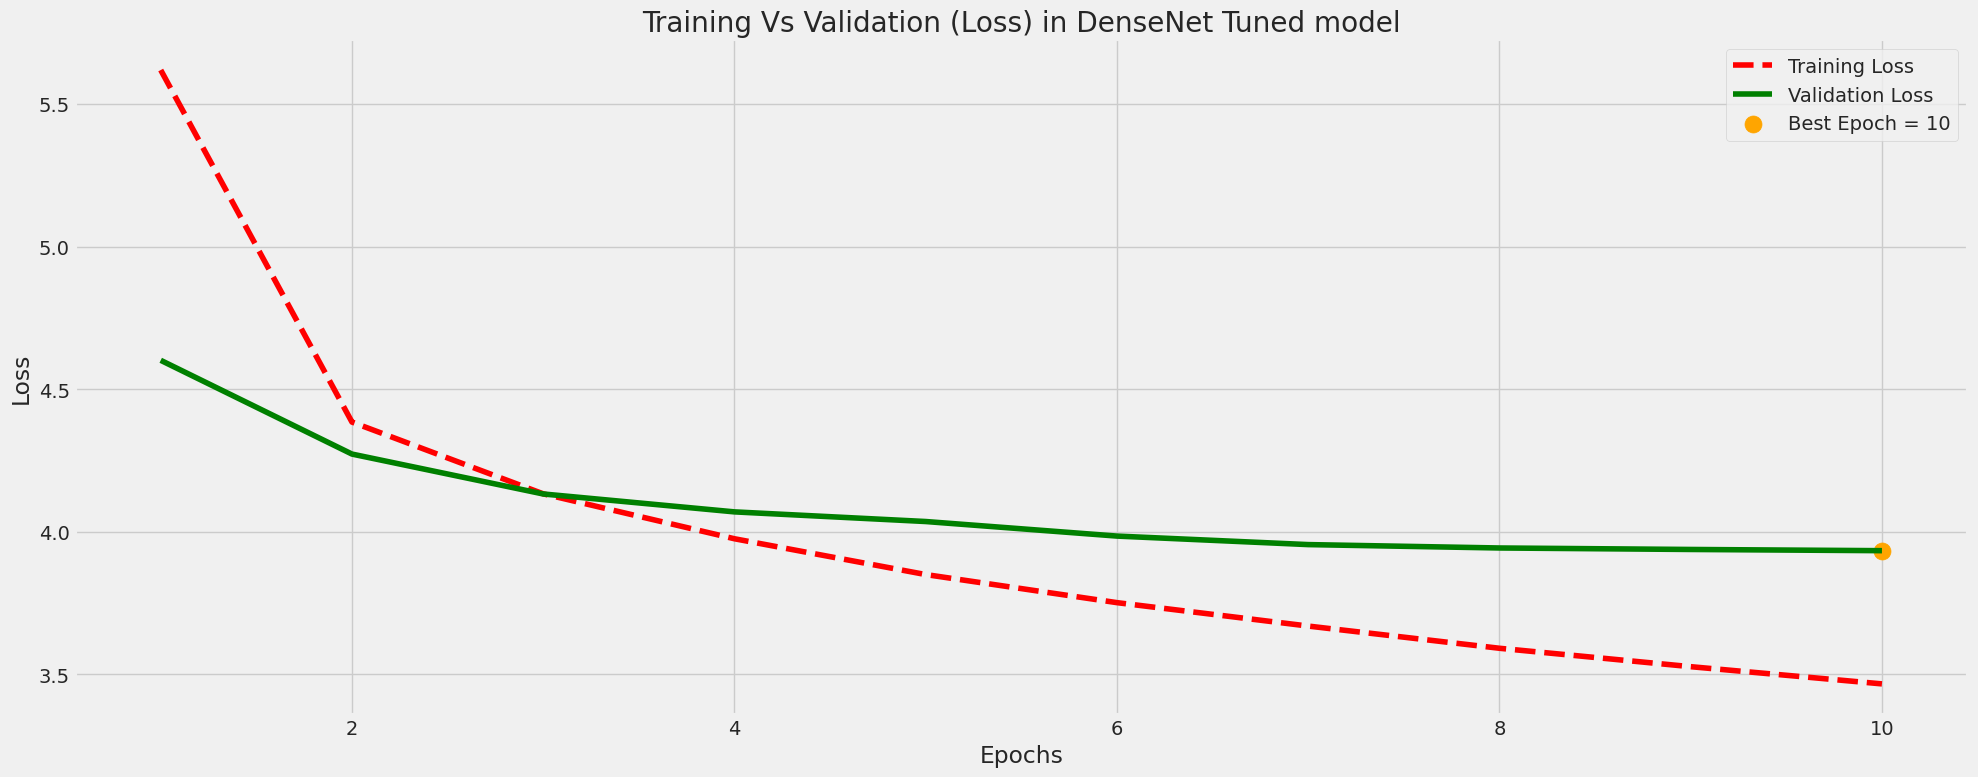

In [60]:
# Extract training and validation metrics from the history object

train_loss = tuned_history.history['loss']
val_loss = tuned_history.history['val_loss']

# Find the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]


# Generate epochs
epochs = [i+1 for i in range(len(train_loss))]

# Define labels for best epochs
loss_label = f'Best Epoch = {str(index_loss + 1)}'

# Plot training and validation loss
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='orange', label=loss_label)
plt.title('Training Vs Validation (Loss) in DenseNet Tuned model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


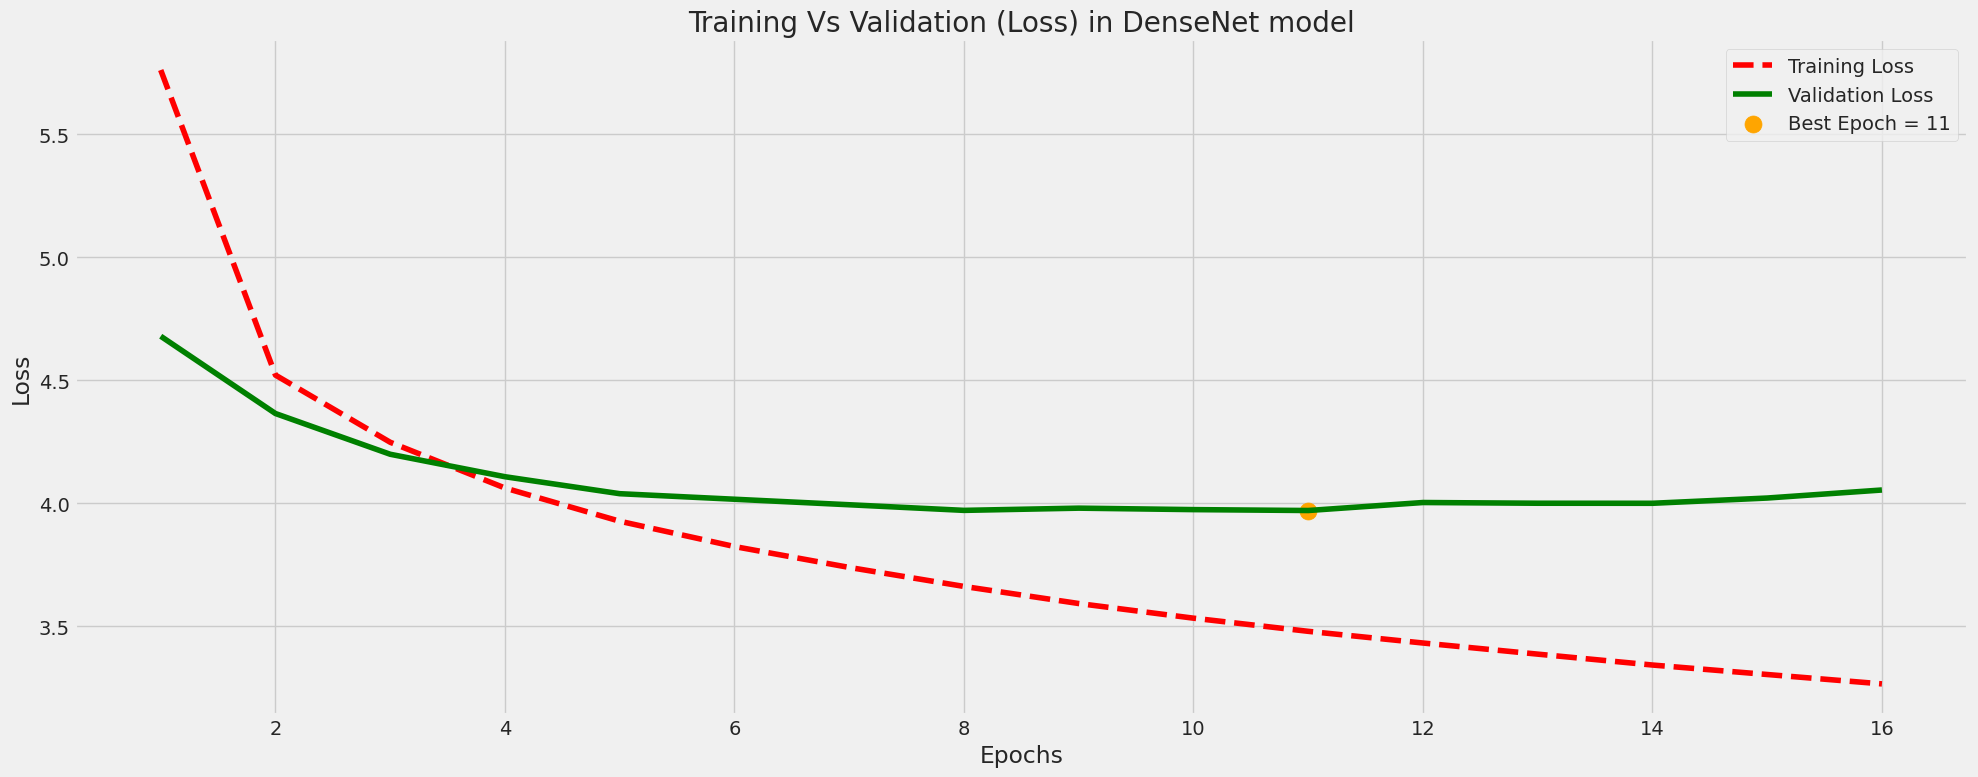

In [78]:
# Extract training and validation metrics from the history object

train_loss = noattention_history.history['loss']
val_loss = noattention_history.history['val_loss']

# Find the epoch with the lowest validation loss
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]


# Generate epochs
epochs = [i+1 for i in range(len(train_loss))]

# Define labels for best epochs
loss_label = f'Best Epoch = {str(index_loss + 1)}'

# Plot training and validation loss
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='orange', label=loss_label)
plt.title('Training Vs Validation (Loss) in DenseNet model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [61]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [62]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

## **Taking 15 Random Samples for Caption Prediction**

In [63]:
# BLEU Evaluation
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu_scores(y_true, y_pred):
    smooth = SmoothingFunction().method4
    bleu_scores = {
        "bleu1": np.mean([sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smooth) for ref, pred in zip(y_true, y_pred)]),
        "bleu2": np.mean([sentence_bleu([ref.split()], pred.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smooth) for ref, pred in zip(y_true, y_pred)]),
        "bleu3": np.mean([sentence_bleu([ref.split()], pred.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth) for ref, pred in zip(y_true, y_pred)]),
        "bleu4": np.mean([sentence_bleu([ref.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth) for ref, pred in zip(y_true, y_pred)]),
    }
    return bleu_scores


In [85]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm
import numpy as np

# 1. Calculate BLEU Scores (Corpus-Level for 5 Captions per Image)
def calculate_bleu_scores1(y_true_dict, y_pred):
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    # Loop through predictions and gather corresponding references
    for img_id, pred in y_pred.items():
        if img_id in y_true_dict:
            refs = [caption.split() for caption in y_true_dict[img_id]]
            references.append(refs)
            candidates.append(pred.split())

    # Calculate BLEU scores using corpus-level BLEU
    bleu_scores = {
        "bleu1": corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
        "bleu2": corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
        "bleu3": corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth),
        "bleu4": corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
    }
    return bleu_scores


# 2. Prepare Test Data (Group 5 Captions per Image)
# Group all 5 captions for each image into a dictionary (img_id: [caption1, caption2, ...])
test_references = test.groupby('image')['caption'].apply(list).to_dict()

# 3. Evaluate on a Subset of Test Data (20 Images for Faster Evaluation)
subset_test_images = test['image'][:20]
subset_y_pred = {}

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model0, img, tokenizer, max_length, features)

    # Tokenize and clean predicted captions
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    # Store predictions (tokenized caption)
    subset_y_pred[img] = " ".join(predicted_caption_tokens)

# 4. Calculate BLEU Scores (5 Captions per Image)
bleu_scores_subset = calculate_bleu_scores1(test_references, subset_y_pred)

# 5. METEOR Evaluation (Handle Multiple References)
meteor_scores = []
for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    meteor = np.mean([meteor_score([ref.split()], pred.split()) for ref in references])
    meteor_scores.append(meteor)

avg_meteor = np.mean(meteor_scores)

# 6. ROUGE Evaluation (Multiple References per Image)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = []

for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    rouge_scores.append(np.mean([rouge.score(ref, pred)['rougeL'].fmeasure for ref in references]))

avg_rouge = np.mean(rouge_scores)

# 7. CIDEr Evaluation (Fixing AssertionError by Using Integer IDs)
cider_metric = Cider()

# Map images to integer IDs to avoid key mismatch
img_to_idx = {img: idx for idx, img in enumerate(subset_test_images)}

# Prepare references (gts) and predictions (res) with integer keys
gts = {img_to_idx[img]: test_references[img] for img in subset_test_images}
res = {img_to_idx[img]: [pred] for img, pred in subset_y_pred.items()}

# Calculate CIDEr score
_, cider_scores = cider_metric.compute_score(gts, res)
avg_cider = np.mean(cider_scores)

# 8. Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']:.4f}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']:.4f}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']:.4f}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']:.4f}")
print(f"METEOR: {avg_meteor:.4f}")
print(f"ROUGE-L: {avg_rouge:.4f}")
print(f"CIDEr: {avg_cider:.4f}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:02<00:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:02<00:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:04<00:10,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:05<00:10,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:06<00:10,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:06<00:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:07<00:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:08<00:06,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:08<00:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:09<00:04,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:10<00:03,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:10<00:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:10<00:02,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:11<00:01,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:11<00:00,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:12<00:00,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]

BLEU-1: 0.6468
BLEU-2: 0.4652
BLEU-3: 0.3729
BLEU-4: 0.2891
METEOR: 0.2338
ROUGE-L: 0.3144
CIDEr: 0.9219


In [89]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm
import numpy as np

# 1. Calculate BLEU Scores (Corpus-Level for 5 Captions per Image)
def calculate_bleu_scores1(y_true_dict, y_pred):
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    # Loop through predictions and gather corresponding references
    for img_id, pred in y_pred.items():
        if img_id in y_true_dict:
            refs = [caption.split() for caption in y_true_dict[img_id]]
            references.append(refs)
            candidates.append(pred.split())

    # Calculate BLEU scores using corpus-level BLEU
    bleu_scores = {
        "bleu1": corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
        "bleu2": corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
        "bleu3": corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth),
        "bleu4": corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
    }
    return bleu_scores


# 2. Prepare Test Data (Group 5 Captions per Image)
# Group all 5 captions for each image into a dictionary (img_id: [caption1, caption2, ...])
test_references = test.groupby('image')['caption'].apply(list).to_dict()

# 3. Evaluate on a Subset of Test Data (20 Images for Faster Evaluation)
subset_test_images = test['image'][:20]
subset_y_pred = {}

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model, img, tokenizer, max_length, features)

    # Tokenize and clean predicted captions
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    # Store predictions (tokenized caption)
    subset_y_pred[img] = " ".join(predicted_caption_tokens)

# 4. Calculate BLEU Scores (5 Captions per Image)
bleu_scores_subset = calculate_bleu_scores1(test_references, subset_y_pred)

# 5. METEOR Evaluation (Handle Multiple References)
meteor_scores = []
for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    meteor = np.mean([meteor_score([ref.split()], pred.split()) for ref in references])
    meteor_scores.append(meteor)

avg_meteor = np.mean(meteor_scores)

# 6. ROUGE Evaluation (Multiple References per Image)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = []

for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    rouge_scores.append(np.mean([rouge.score(ref, pred)['rougeL'].fmeasure for ref in references]))

avg_rouge = np.mean(rouge_scores)

# 7. CIDEr Evaluation (Fixing AssertionError by Using Integer IDs)
cider_metric = Cider()

# Map images to integer IDs to avoid key mismatch
img_to_idx = {img: idx for idx, img in enumerate(subset_test_images)}

# Prepare references (gts) and predictions (res) with integer keys
gts = {img_to_idx[img]: test_references[img] for img in subset_test_images}
res = {img_to_idx[img]: [pred] for img, pred in subset_y_pred.items()}

# Calculate CIDEr score
_, cider_scores = cider_metric.compute_score(gts, res)
avg_cider = np.mean(cider_scores)

# 8. Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']:.4f}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']:.4f}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']:.4f}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']:.4f}")
print(f"METEOR: {avg_meteor:.4f}")
print(f"ROUGE-L: {avg_rouge:.4f}")
print(f"CIDEr: {avg_cider:.4f}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:02<00:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:03<00:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:04<00:14,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:05<00:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:06<00:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:07<00:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:07<00:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:08<00:07,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:10<00:09,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:11<00:09,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:13<00:09,  1.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:14<00:08,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:16<00:07,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:16<00:04,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:17<00:02,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:18<00:01,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:18<00:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

BLEU-1: 0.4364
BLEU-2: 0.2925
BLEU-3: 0.1970
BLEU-4: 0.0908
METEOR: 0.2110
ROUGE-L: 0.2262
CIDEr: 0.4800


In [90]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm
import numpy as np

# 1. Calculate BLEU Scores (Corpus-Level for 5 Captions per Image)
def calculate_bleu_scores1(y_true_dict, y_pred):
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    # Loop through predictions and gather corresponding references
    for img_id, pred in y_pred.items():
        if img_id in y_true_dict:
            refs = [caption.split() for caption in y_true_dict[img_id]]
            references.append(refs)
            candidates.append(pred.split())

    # Calculate BLEU scores using corpus-level BLEU
    bleu_scores = {
        "bleu1": corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
        "bleu2": corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
        "bleu3": corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth),
        "bleu4": corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
    }
    return bleu_scores


# 2. Prepare Test Data (Group 5 Captions per Image)
# Group all 5 captions for each image into a dictionary (img_id: [caption1, caption2, ...])
test_references = test.groupby('image')['caption'].apply(list).to_dict()

# 3. Evaluate on a Subset of Test Data (20 Images for Faster Evaluation)
subset_test_images = test['image'][:20]
subset_y_pred = {}

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model1, img, tokenizer, max_length, features)

    # Tokenize and clean predicted captions
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    # Store predictions (tokenized caption)
    subset_y_pred[img] = " ".join(predicted_caption_tokens)

# 4. Calculate BLEU Scores (5 Captions per Image)
bleu_scores_subset = calculate_bleu_scores1(test_references, subset_y_pred)

# 5. METEOR Evaluation (Handle Multiple References)
meteor_scores = []
for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    meteor = np.mean([meteor_score([ref.split()], pred.split()) for ref in references])
    meteor_scores.append(meteor)

avg_meteor = np.mean(meteor_scores)

# 6. ROUGE Evaluation (Multiple References per Image)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = []

for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    rouge_scores.append(np.mean([rouge.score(ref, pred)['rougeL'].fmeasure for ref in references]))

avg_rouge = np.mean(rouge_scores)

# 7. CIDEr Evaluation (Fixing AssertionError by Using Integer IDs)
cider_metric = Cider()

# Map images to integer IDs to avoid key mismatch
img_to_idx = {img: idx for idx, img in enumerate(subset_test_images)}

# Prepare references (gts) and predictions (res) with integer keys
gts = {img_to_idx[img]: test_references[img] for img in subset_test_images}
res = {img_to_idx[img]: [pred] for img, pred in subset_y_pred.items()}

# Calculate CIDEr score
_, cider_scores = cider_metric.compute_score(gts, res)
avg_cider = np.mean(cider_scores)

# 8. Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']:.4f}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']:.4f}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']:.4f}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']:.4f}")
print(f"METEOR: {avg_meteor:.4f}")
print(f"ROUGE-L: {avg_rouge:.4f}")
print(f"CIDEr: {avg_cider:.4f}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:09,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:01<00:09,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:02<00:08,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:02<00:07,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:04<00:08,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:04<00:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:05<00:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:06<00:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:07<00:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:07<00:04,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:08<00:03,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:10<00:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:10<00:01,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:11<00:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]

BLEU-1: 0.6364
BLEU-2: 0.4444
BLEU-3: 0.3442
BLEU-4: 0.2477
METEOR: 0.2545
ROUGE-L: 0.3168
CIDEr: 1.1044


In [36]:
from tqdm import tqdm

# Evaluate on a subset of the test dataset (e.g., first 20 images)
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model, img, tokenizer, max_length, features)
    subset_y_pred.append(predicted_caption)

bleu_scores_subset = calculate_bleu_scores(subset_y_true, subset_y_pred)

print(f"BLEU-1: {bleu_scores_subset['bleu1']}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:01<00:23,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:02<00:18,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:03<00:17,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:04<00:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:05<00:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:05<00:12,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:06<00:10,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:07<00:09,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:07<00:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:08<00:07,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:09<00:08,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:11<00:09,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:13<00:08,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:14<00:07,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:16<00:06,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:16<00:04,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:17<00:02,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:17<00:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:18<00:00,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:18<00:00,  1.06it/s]

BLEU-1: 0.18610328955725572
BLEU-2: 0.10596770237924025
BLEU-3: 0.0696930283728375
BLEU-4: 0.04361079406994399


In [37]:
!pip install rouge-score

In [38]:
!pip install pycocoevalcap

In [39]:
!pip install nltk # Make sure NLTK is installed
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

# Evaluate on a subset of the test dataset (e.g., first 20 images)
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model, img, tokenizer, max_length, features)

    # Tokenize the predicted caption and remove special tokens
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()

    # Remove padding (token '0') from predictions
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    subset_y_pred.append(predicted_caption_tokens)

# BLEU Scores (Modify to handle tokenized predictions)
bleu_scores_subset = calculate_bleu_scores(subset_y_true, [" ".join(pred_tokens) for pred_tokens in subset_y_pred])

# METEOR Score (Pass tokenized predictions)
meteor_scores = [meteor_score([true.split()], pred) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score (Join tokens back into a string)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, " ".join(pred))['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap - Join tokens back into a string)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [" ".join(pred)] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:18,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:17,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:03<00:17,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:04<00:16,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:05<00:15,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:05<00:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:06<00:11,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:07<00:10,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:08<00:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:08<00:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:10<00:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:11<00:09,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:13<00:09,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:15<00:08,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:16<00:07,  1.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:17<00:04,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:17<00:03,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:18<00:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:19<00:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


BLEU-1: 0.21077683657813107
BLEU-2: 0.11985199631357255
BLEU-3: 0.0785803373436246
BLEU-4: 0.049237843795415084
METEOR: 0.25781374917753197
ROUGE-L: 0.24929814962810104
CIDEr: 0.3844646186510242


In [64]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

# Evaluate on a subset of the test dataset (e.g., first 20 images)
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model1, img, tokenizer, max_length, features)

    # Tokenize the predicted caption and remove special tokens
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()

    # Remove padding (token '0') from predictions
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    subset_y_pred.append(predicted_caption_tokens)

# BLEU Scores (Modify to handle tokenized predictions)
bleu_scores_subset = calculate_bleu_scores(subset_y_true, [" ".join(pred_tokens) for pred_tokens in subset_y_pred])

# METEOR Score (Pass tokenized predictions)
meteor_scores = [meteor_score([true.split()], pred) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score (Join tokens back into a string)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, " ".join(pred))['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap - Join tokens back into a string)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [" ".join(pred)] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:14,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:01<00:09,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:03<00:08,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:04<00:07,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:04<00:07,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:07<00:04,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:09<00:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:09<00:02,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:10<00:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:11<00:00,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]

BLEU-1: 0.2820193122155382
BLEU-2: 0.19154414057983565
BLEU-3: 0.1402856640401216
BLEU-4: 0.09951601358208581
METEOR: 0.31440032073063107
ROUGE-L: 0.3560201124984407
CIDEr: 0.9042393521749041


In [79]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider

# Evaluate on a subset of the test dataset (e.g., first 20 images)
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions for subset"):
    predicted_caption = predict_caption(caption_model0, img, tokenizer, max_length, features)

    # Tokenize the predicted caption and remove special tokens
    predicted_caption_tokens = predicted_caption.replace('startseq', '').replace('endseq', '').strip().split()

    # Remove padding (token '0') from predictions
    predicted_caption_tokens = [word for word in predicted_caption_tokens if word != '0']

    subset_y_pred.append(predicted_caption_tokens)

# BLEU Scores (Modify to handle tokenized predictions)
bleu_scores_subset = calculate_bleu_scores(subset_y_true, [" ".join(pred_tokens) for pred_tokens in subset_y_pred])

# METEOR Score (Pass tokenized predictions)
meteor_scores = [meteor_score([true.split()], pred) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score (Join tokens back into a string)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, " ".join(pred))['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap - Join tokens back into a string)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [" ".join(pred)] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions for subset:   0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:   5%|▌         | 1/20 [00:00<00:17,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  10%|█         | 2/20 [00:01<00:13,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  20%|██        | 4/20 [00:02<00:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  30%|███       | 6/20 [00:04<00:09,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  40%|████      | 8/20 [00:05<00:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Generating predictions for subset:  45%|████▌     | 9/20 [00:06<00:08,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  50%|█████     | 10/20 [00:07<00:07,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Generating predictions for subset:  55%|█████▌    | 11/20 [00:08<00:06,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  60%|██████    | 12/20 [00:08<00:05,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  65%|██████▌   | 13/20 [00:09<00:04,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  70%|███████   | 14/20 [00:09<00:03,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  75%|███████▌  | 15/20 [00:10<00:02,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset:  80%|████████  | 16/20 [00:10<00:01,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  85%|████████▌ | 17/20 [00:10<00:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  90%|█████████ | 18/20 [00:11<00:00,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Generating predictions for subset:  95%|█████████▌| 19/20 [00:11<00:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating predictions for subset: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]

BLEU-1: 0.25882258127510466
BLEU-2: 0.1673335299806145
BLEU-3: 0.1124800039205602
BLEU-4: 0.08362564051036839
METEOR: 0.28842903503954187
ROUGE-L: 0.3549616461969403
CIDEr: 0.8895685441909278


In [ ]:
!pip install nltk # Make sure NLTK is installed
import nltk
nltk.download('wordnet') # Download WordNet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [65]:
samples1 = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [80]:
samples0 = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [42]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [66]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model1, record['image'], tokenizer, max_length, features)
    samples1.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [81]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model0, record['image'], tokenizer, max_length, features)
    samples0.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

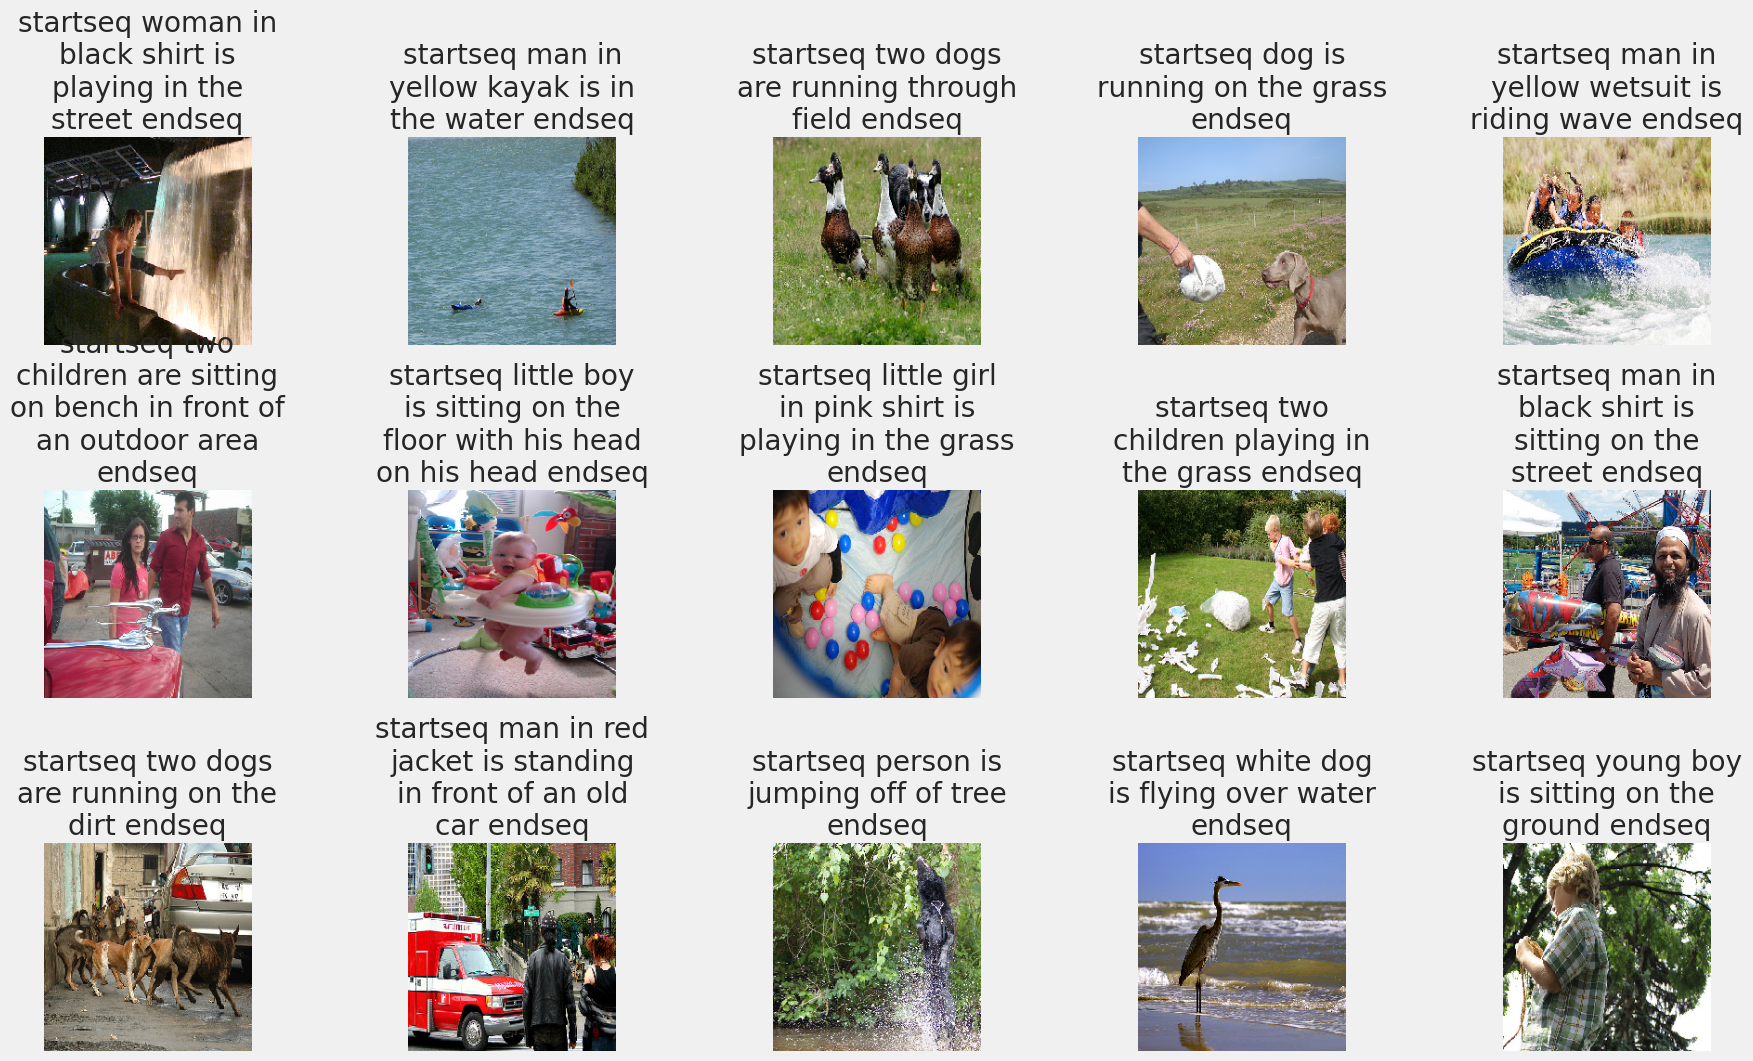

In [43]:
display_images(samples)

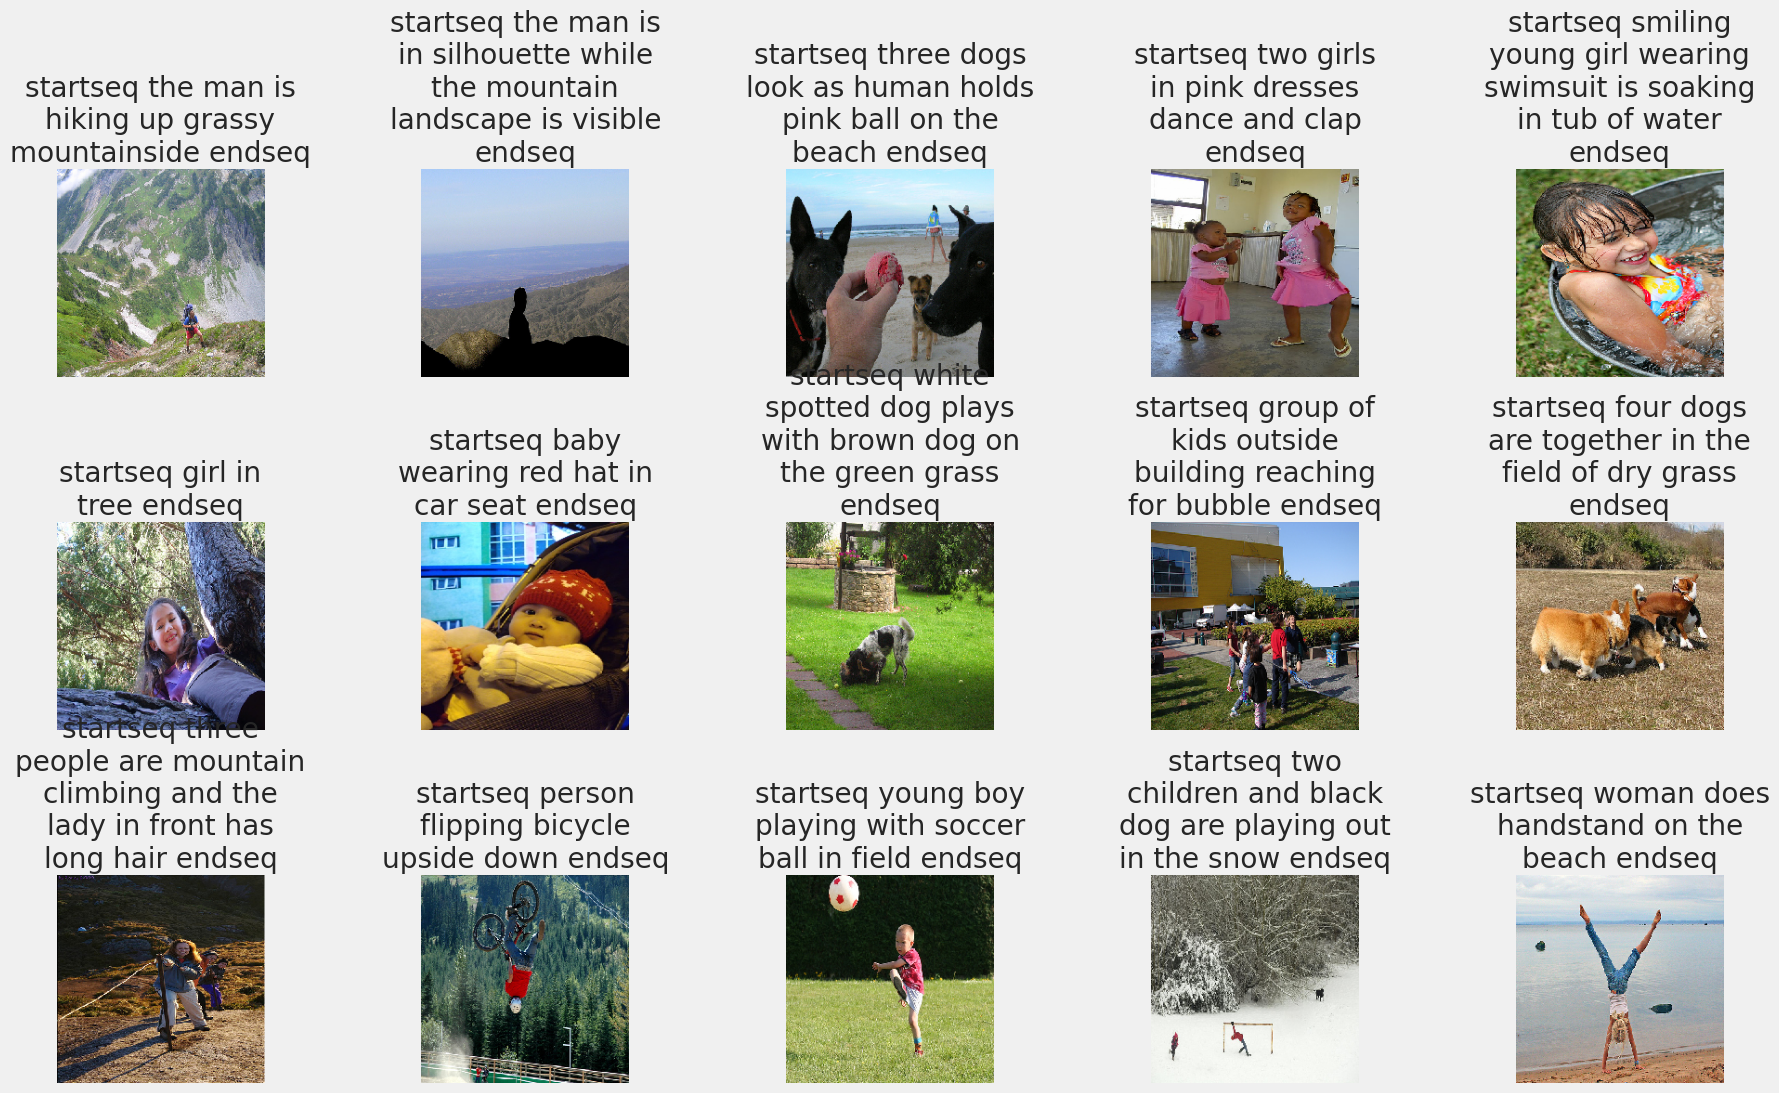

In [67]:
display_images(samples1)

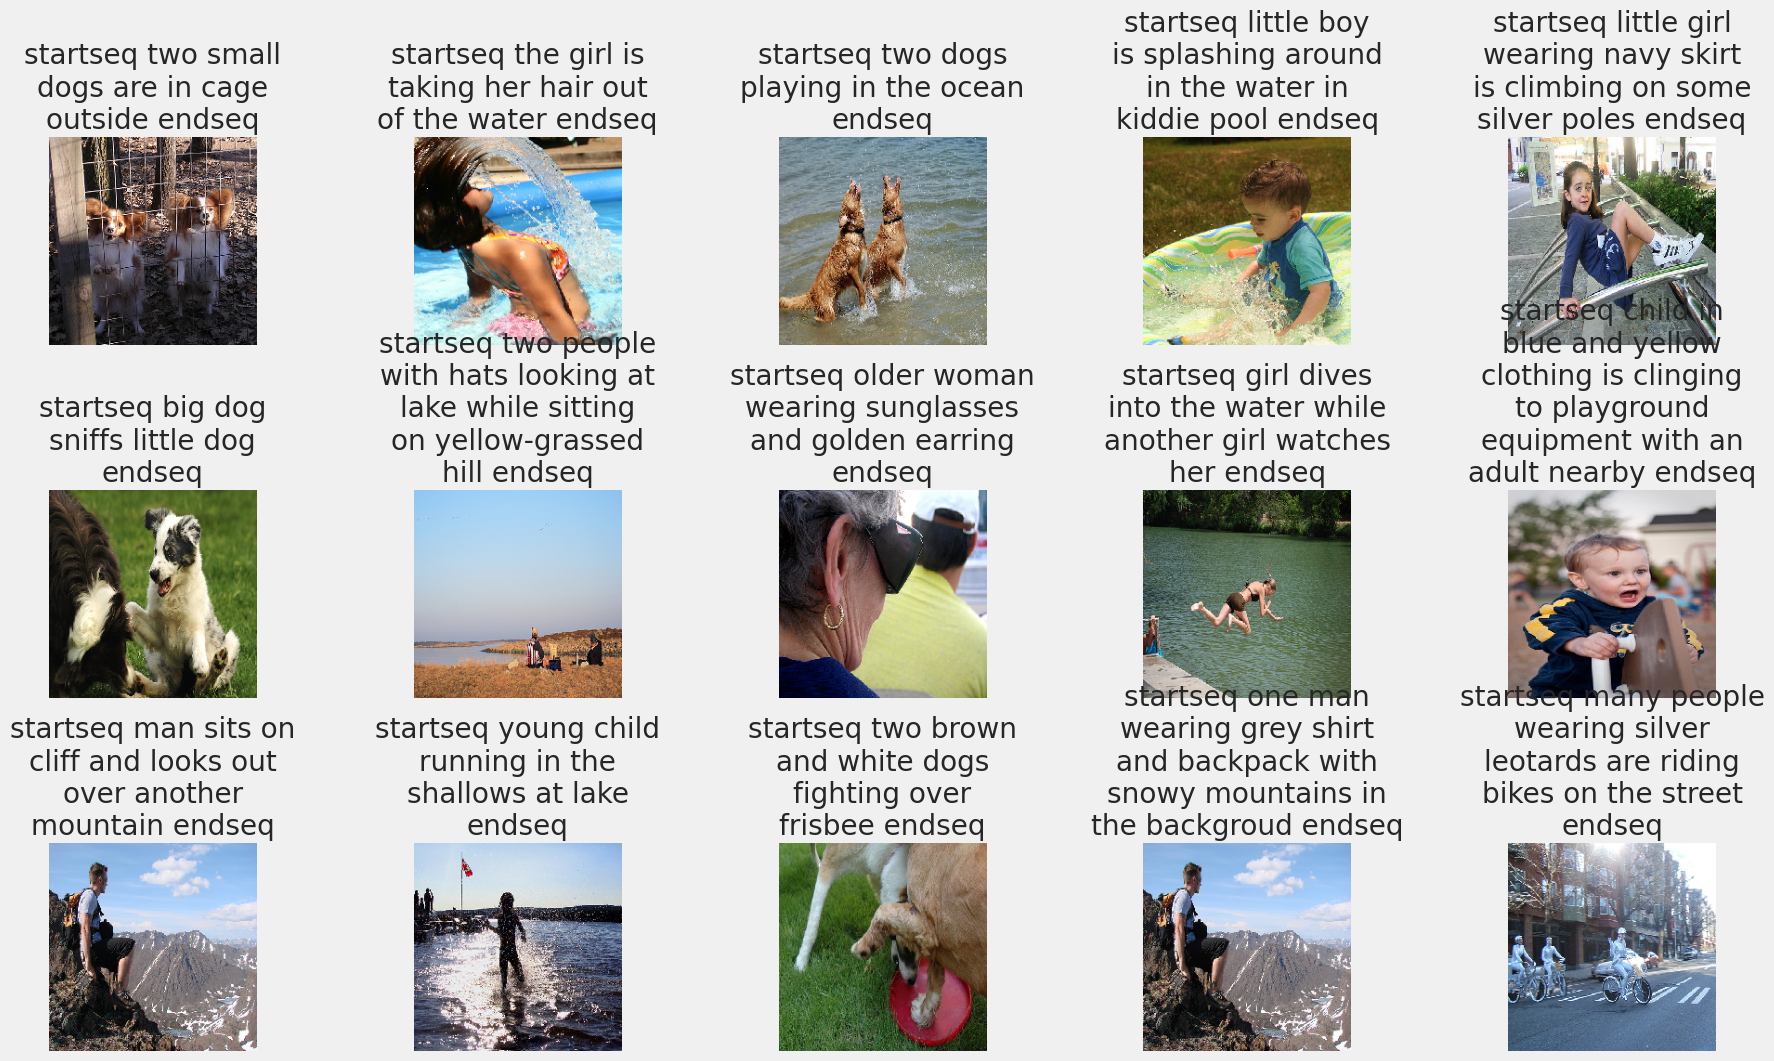

In [82]:
display_images(samples0)

In [44]:
from tqdm import tqdm
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=5):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    # Start with the initial sequence
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            # Convert sequence to tokens
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            # Predict next word probabilities
            y_pred = model.predict([feature, sequence], verbose=0)[0]

            # Get top `beam_width` predictions
            top_indices = np.argsort(y_pred)[-beam_width:]

            # Create new candidate sequences
            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                # Append candidate to the list
                all_candidates.append((new_seq, new_score))

        # Order candidates by score and select the top `beam_width`
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]

    # Return the sequence with the highest score
    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model, feature, tokenizer, max_length, beam_width=3)
    subset_y_pred.append(predicted_caption)

# Evaluate BLEU Scores
bleu_scores = calculate_bleu_scores(subset_y_true, subset_y_pred)

print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")


Generating predictions with beam search: 100%|██████████| 20/20 [02:01<00:00,  6.08s/it]

BLEU-1: 0.22616992922163343
BLEU-2: 0.15152282880563042
BLEU-3: 0.11070404432157499
BLEU-4: 0.08066717530110722


In [46]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=3):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            y_pred = model.predict([feature, sequence], verbose=0)[0]
            top_indices = np.argsort(y_pred)[-beam_width:]

            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model, feature, tokenizer, max_length, beam_width=3)
    subset_y_pred.append(predicted_caption)

# BLEU Scores
bleu_scores = calculate_bleu_scores(subset_y_true, subset_y_pred)

# METEOR Score
meteor_scores = [meteor_score([true.split()], pred.split()) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, pred)['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [pred] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions with beam search: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]

BLEU-1: 0.22616992922163343
BLEU-2: 0.15152282880563042
BLEU-3: 0.11070404432157499
BLEU-4: 0.08066717530110722
METEOR: 0.28165115376519845
ROUGE-L: 0.31400280831248584
CIDEr: 0.8029382888165459


In [68]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=3):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            y_pred = model.predict([feature, sequence], verbose=0)[0]
            top_indices = np.argsort(y_pred)[-beam_width:]

            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model1, feature, tokenizer, max_length, beam_width=3)
    subset_y_pred.append(predicted_caption)

# BLEU Scores
bleu_scores = calculate_bleu_scores(subset_y_true, subset_y_pred)

# METEOR Score
meteor_scores = [meteor_score([true.split()], pred.split()) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, pred)['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [pred] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions with beam search: 100%|██████████| 20/20 [02:00<00:00,  6.01s/it]

BLEU-1: 0.23072953409027946
BLEU-2: 0.1471519852739393
BLEU-3: 0.0968013271413761
BLEU-4: 0.06973972412343916
METEOR: 0.24612760776082926
ROUGE-L: 0.3100180594259541
CIDEr: 0.7083664093497142


In [70]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=5,length_penalty = 0.7
):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            y_pred = model.predict([feature, sequence], verbose=0)[0]
            top_indices = np.argsort(y_pred)[-beam_width:]

            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model1, feature, tokenizer, max_length, beam_width=3)
    subset_y_pred.append(predicted_caption)

# BLEU Scores
bleu_scores = calculate_bleu_scores(subset_y_true, subset_y_pred)

# METEOR Score
meteor_scores = [meteor_score([true.split()], pred.split()) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, pred)['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [pred] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions with beam search: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]

BLEU-1: 0.23072953409027946
BLEU-2: 0.1471519852739393
BLEU-3: 0.0968013271413761
BLEU-4: 0.06973972412343916
METEOR: 0.24612760776082926
ROUGE-L: 0.3100180594259541
CIDEr: 0.7083664093497142


In [83]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=7,length_penalty = 0.8):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            y_pred = model.predict([feature, sequence], verbose=0)[0]
            top_indices = np.argsort(y_pred)[-beam_width:]

            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model0, feature, tokenizer, max_length, beam_width=3)
    subset_y_pred.append(predicted_caption)

# BLEU Scores
bleu_scores = calculate_bleu_scores(subset_y_true, subset_y_pred)

# METEOR Score
meteor_scores = [meteor_score([true.split()], pred.split()) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, pred)['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [pred] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions with beam search: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]

BLEU-1: 0.27390013923083684
BLEU-2: 0.16877304110139504
BLEU-3: 0.11294192374481601
BLEU-4: 0.08298076776507096
METEOR: 0.2940029471963935
ROUGE-L: 0.3418486317603964
CIDEr: 0.8459605239893826


In [91]:
from tqdm import tqdm
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
import numpy as np

def beam_search_predict(model, feature, tokenizer, max_length, beam_width=7,length_penalty = 0.8):
    """
    Predict captions using beam search.

    :param model: Trained caption model.
    :param feature: Image feature from the feature extractor.
    :param tokenizer: Tokenizer used for text preprocessing.
    :param max_length: Maximum length of the caption.
    :param beam_width: Number of sequences to keep at each step.
    :return: The best predicted caption.
    """
    start_seq = "startseq"
    sequences = [(start_seq, 0.0)]  # (sequence, score)

    for _ in range(max_length):
        all_candidates = []

        # Iterate through current sequences
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length,padding='post')

            y_pred = model.predict([feature, sequence], verbose=0)[0]
            top_indices = np.argsort(y_pred)[-beam_width:]

            for idx in top_indices:
                word = tokenizer.index_word.get(idx, None)
                if word is None:
                    continue

                new_seq = seq + " " + word
                new_score = score + np.log(y_pred[idx])

                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

    final_sequence = sequences[0][0]
    return final_sequence.replace("startseq", "").replace("endseq", "").strip()

# Evaluate on 20 images only
subset_test_images = test['image'][:20]
subset_y_true = test['caption'][:20].apply(lambda x: x.replace('startseq', '').replace('endseq', '').strip()).tolist()
subset_y_pred = []

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    feature = features[img]
    predicted_caption = beam_search_predict(caption_model0, feature, tokenizer, max_length, beam_width=7)
    subset_y_pred.append(predicted_caption)

# BLEU Scores
bleu_scores = calculate_bleu_scores1(subset_y_true, subset_y_pred)

# METEOR Score
meteor_scores = [meteor_score([true.split()], pred.split()) for true, pred in zip(subset_y_true, subset_y_pred)]
avg_meteor = np.mean(meteor_scores)

# ROUGE Score
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(true, pred)['rougeL'].fmeasure for true, pred in zip(subset_y_true, subset_y_pred)]
avg_rouge = np.mean(rouge_scores)

# CIDEr Score (Using pycocoevalcap)
cider_metric = Cider()
_, cider_scores = cider_metric.compute_score(
    {idx: [ref] for idx, ref in enumerate(subset_y_true)},
    {idx: [pred] for idx, pred in enumerate(subset_y_pred)}
)
avg_cider = np.mean(cider_scores)

# Print Evaluation Results
print(f"BLEU-1: {bleu_scores['bleu1']}")
print(f"BLEU-2: {bleu_scores['bleu2']}")
print(f"BLEU-3: {bleu_scores['bleu3']}")
print(f"BLEU-4: {bleu_scores['bleu4']}")
print(f"METEOR: {avg_meteor}")
print(f"ROUGE-L: {avg_rouge}")
print(f"CIDEr: {avg_cider}")


Generating predictions with beam search: 100%|██████████| 20/20 [04:45<00:00, 14.29s/it]


AttributeError: 'list' object has no attribute 'items'

In [92]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm
import numpy as np

# 1. Beam Search Caption Generation
def beam_search_caption(model, image, tokenizer, max_length, features, beam_width=3):
    start_seq = "startseq"
    sequences = [[start_seq, 0.0]]

    # Iterate over max length
    for _ in range(max_length):
        all_candidates = []

        # Expand each sequence
        for seq, score in sequences:
            if seq.split()[-1] == 'endseq':
                all_candidates.append((seq, score))
                continue

            # Encode the current sequence
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

            # Predict next word probabilities
            y_pred = model.predict([features[image], sequence], verbose=0)
            top_k = np.argsort(y_pred[0])[-beam_width:]

            # Expand beam width
            for word_idx in top_k:
                word = idx_to_word(word_idx, tokenizer)
                new_seq = seq + ' ' + word
                new_score = score + np.log(y_pred[0][word_idx])
                all_candidates.append((new_seq, new_score))

        # Sort candidates by score
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = ordered[:beam_width]  # Select top-k sequences

    # Return best sequence (without startseq/endseq)
    final_caption = sequences[0][0].split()
    return " ".join(final_caption[1:-1])  # Remove startseq and endseq

# 2. Calculate BLEU Scores (Corpus-Level for 5 Captions per Image)
def calculate_bleu_scores(y_true_dict, y_pred):
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    # Loop through predictions and gather corresponding references
    for img_id, pred in y_pred.items():
        if img_id in y_true_dict:
            refs = [caption.split() for caption in y_true_dict[img_id]]
            references.append(refs)
            candidates.append(pred.split())

    # Calculate BLEU scores using corpus-level BLEU
    bleu_scores = {
        "bleu1": corpus_bleu(references, candidates, weights=(1.0, 0, 0, 0), smoothing_function=smooth),
        "bleu2": corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth),
        "bleu3": corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth),
        "bleu4": corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth),
    }
    return bleu_scores

# 3. Prepare Test Data (Group 5 Captions per Image)
# Group all 5 captions for each image into a dictionary (img_id: [caption1, caption2, ...])
test_references = test.groupby('image')['caption'].apply(list).to_dict()

# 4. Evaluate on a Subset of Test Data (20 Images for Faster Evaluation)
subset_test_images = test['image'][:20]
subset_y_pred = {}

for img in tqdm(subset_test_images, desc="Generating predictions with beam search"):
    predicted_caption = beam_search_caption(caption_model0, img, tokenizer, max_length, features, beam_width=5)
    subset_y_pred[img] = predicted_caption

# 5. Calculate BLEU Scores (5 Captions per Image)
bleu_scores_subset = calculate_bleu_scores(test_references, subset_y_pred)

# 6. METEOR Evaluation (Handle Multiple References)
meteor_scores = []
for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    meteor = np.mean([meteor_score([ref.split()], pred.split()) for ref in references])
    meteor_scores.append(meteor)

avg_meteor = np.mean(meteor_scores)

# 7. ROUGE Evaluation (Multiple References per Image)
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = []

for img_id, pred in subset_y_pred.items():
    references = test_references[img_id]
    rouge_scores.append(np.mean([rouge.score(ref, pred)['rougeL'].fmeasure for ref in references]))

avg_rouge = np.mean(rouge_scores)

# 8. CIDEr Evaluation (Fixing AssertionError by Using Integer IDs)
cider_metric = Cider()

# Map images to integer IDs to avoid key mismatch
img_to_idx = {img: idx for idx, img in enumerate(subset_test_images)}

# Prepare references (gts) and predictions (res) with integer keys
gts = {img_to_idx[img]: test_references[img] for img in subset_test_images}
res = {img_to_idx[img]: [pred] for img, pred in subset_y_pred.items()}

# Calculate CIDEr score
_, cider_scores = cider_metric.compute_score(gts, res)
avg_cider = np.mean(cider_scores)

# 9. Print Evaluation Results
print(f"BLEU-1: {bleu_scores_subset['bleu1']:.4f}")
print(f"BLEU-2: {bleu_scores_subset['bleu2']:.4f}")
print(f"BLEU-3: {bleu_scores_subset['bleu3']:.4f}")
print(f"BLEU-4: {bleu_scores_subset['bleu4']:.4f}")
print(f"METEOR: {avg_meteor:.4f}")
print(f"ROUGE-L: {avg_rouge:.4f}")
print(f"CIDEr: {avg_cider:.4f}")


Generating predictions with beam search: 100%|██████████| 20/20 [00:59<00:00,  2.98s/it]

BLEU-1: 0.5597
BLEU-2: 0.4019
BLEU-3: 0.3294
BLEU-4: 0.2725
METEOR: 0.1974
ROUGE-L: 0.2881
CIDEr: 0.8538
